In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

In [2]:
import yfinance as yf
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 設定股票代號和日期範圍
ticker = 'MTCH'
start_date = '2018-11-11'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

# 下載股票數據
data = yf.download(ticker, start=start_date, end=end_date)

# 保存為 CSV 文件
csv_path = "./MTCH_stock_data_2018_11_11_to_today.csv"
data.to_csv(csv_path)

print(f"數據已保存到 {csv_path}")

[*********************100%***********************]  1 of 1 completed

數據已保存到 ./MTCH_stock_data_2018_11_11_to_today.csv


In [ ]:
from imblearn.over_sampling import SMOTE

# 查看每個類別的分佈
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before SMOTE: {dict(zip(y_values, y_counts))}")

# 定義 SMOTE 的 sampling_strategy
sampling_strategy = {
    0: y_counts[0],  # 保持類別 0 的樣本數量不變
    1: y_counts[0],  # 將類別 1 增加到與類別 0 相同的數量
    2: y_counts[0]   # 將類別 2 增加到與類別 0 相同的數量
}

# 使用 SMOTE 進行上採樣處理以平衡類別
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# 查看 SMOTE 後的類別分佈
y_values, y_counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(y_values, y_counts))}")


Class distribution before SMOTE: {0: 719, 1: 60, 2: 701}
Class distribution after SMOTE: {0: 719, 1: 719, 2: 719}


Class distribution before SMOTE: {0: 719, 1: 60, 2: 702}
Class distribution after SMOTE: {0: 719, 1: 359, 2: 719}
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'class_weight': 'balanced_subsample', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Average Cross-Validation Score: 0.4760


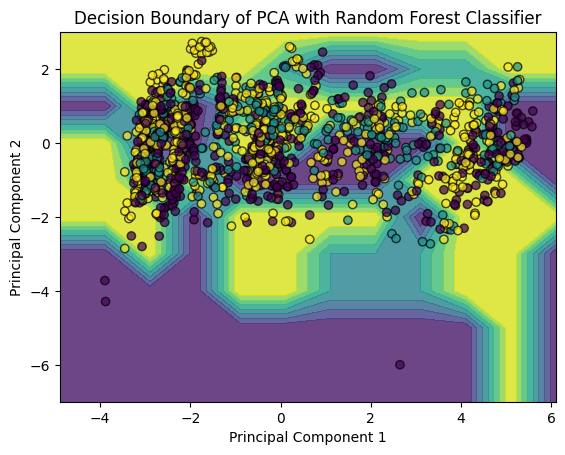

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()
# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 創建標籤欄位
df['Label'] = None
w = 14  # 歷史窗口大小
h = 7   # 預測視窗大小

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'  # 上升
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'  # 下降
    else:
        df.at[df.index[t], 'Label'] = 'M'  # 保持

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇 (取多個欄位作為特徵)
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼 (將 U, D, M 轉換為數字)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 查看每個類別的分佈
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before SMOTE: {dict(zip(y_values, y_counts))}")

# 定義 SMOTE 的 sampling_strategy，讓 M 類別稍微多一些但不過於誇張
sampling_strategy = {
    0: y_counts[0],  # 保持類別 0 的樣本數量不變
    1: y_counts[0] // 2,  # 增加到與類別 0 相同的數量的一半
    2: y_counts[0]  # 增加到與類別 0 相同的數量
}

# 使用 SMOTE 進行上採樣處理以平衡類別
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

# 查看 SMOTE 後的類別分佈
y_values, y_counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(y_values, y_counts))}")

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# 應用 PCA 將數據降維到 2 維
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 使用 GridSearchCV 調整隨機森林參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

# 使用最佳參數訓練隨機森林分類器
best_rf_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_rf_clf, X_train_pca, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪製決策邊界
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

# 繪製數據點
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', alpha=0.7, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of PCA with Random Forest Classifier')
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()
# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 創建標籤欄位
df['Label'] = None
w = 30  # 歷史窗口大小
h = 7   # 預測視窗大小

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'  # 上升
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'  # 下降
    else:
        df.at[df.index[t], 'Label'] = 'M'  # 保持

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇 (取多個欄位作為特徵)
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼 (將 U, D, M 轉換為數字)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 使用 SMOTE 進行上採樣處理以平衡類別
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before SMOTE: {dict(zip(y_values, y_counts))}")
sampling_strategy = {
    0: y_counts[0],  # 保持類別 0 的樣本數量不變
    1: y_counts[0],  # 增加到與類別 0 相同的數量
    2: int(y_counts[0] * 0.5)  # 增加到類別 0 的一半
}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
y_values, y_counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(y_values, y_counts))}")

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# 應用 PCA 將數據降維到 2 維
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 使用 GridSearchCV 調整 XGBoost 分類器參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}
xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

# 使用最佳參數訓練 XGBoost 分類器
best_xgb_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_xgb_clf, X_train_pca, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# 使用模型進行預測
Z = best_xgb_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪製決策邊界
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

# 繪製數據點
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', alpha=0.7, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of PCA with XGBoost Classifier')
plt.show()


Class distribution before SMOTE: {0: 719, 1: 60, 2: 701}


ValueError: With over-sampling methods, the number of samples in a class should be greater or equal to the original number of samples. Originally, there is 701 samples and 359 samples are asked.

In [ ]:
from sklearn.utils import resample

# 查看每個類別的分佈
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before resampling: {dict(zip(y_values, y_counts))}")

# 將原始資料劃分為三個類別
class_0 = labeled_df[y_encoded == 0]
class_1 = labeled_df[y_encoded == 1]  # 類別 1（你要增加的）
class_2 = labeled_df[y_encoded == 2]

# 對類別 1 進行上採樣，增加一些樣本
class_1_upsampled = resample(class_1,
                             replace=True,             # 允許重複選取
                             n_samples=int(y_counts[1] * 3),  # 增加到原始樣本的3倍
                             random_state=42)

# 合併類別，類別 0 和 2 保持不變，只增加類別 1 的樣本
resampled_df = pd.concat([class_0, class_1_upsampled, class_2])

# 重新定義 X 和 y
X_resampled = resampled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y_resampled = resampled_df['Label']

# 對標籤進行編碼
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# 查看最終分佈
y_values, y_counts = np.unique(y_resampled_encoded, return_counts=True)
print(f"Class distribution after resampling: {dict(zip(y_values, y_counts))}")


Class distribution before resampling: {0: 719, 1: 60, 2: 701}
Class distribution after resampling: {0: 719, 1: 180, 2: 701}


Class distribution before resampling: {0: 719, 1: 60, 2: 702}
Class distribution after resampling: {0: 719, 1: 300, 2: 702}
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Average Cross-Validation Score: 0.6468


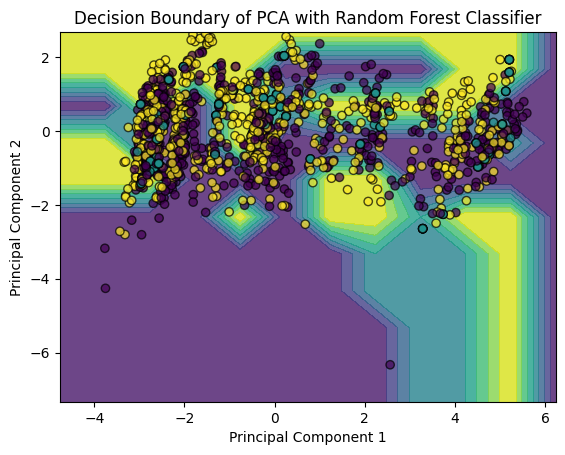

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()
# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 創建標籤欄位
df['Label'] = None
w = 30  # 歷史窗口大小
h = 7   # 預測視窗大小

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'  # 上升
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'  # 下降
    else:
        df.at[df.index[t], 'Label'] = 'M'  # 保持

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇 (取多個欄位作為特徵)
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼 (將 U, D, M 轉換為數字)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 查看每個類別的分佈
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before resampling: {dict(zip(y_values, y_counts))}")

# 將原始資料劃分為三個類別
class_0 = labeled_df[y_encoded == 0]
class_1 = labeled_df[y_encoded == 1]  # 類別 1（要增加的）
class_2 = labeled_df[y_encoded == 2]

# 對類別 1 進行上採樣，增加一些樣本
class_1_upsampled = resample(class_1,
                             replace=True,             # 允許重複選取
                             n_samples=int(y_counts[1] * 5),  # 增加到原始樣本的3倍
                             random_state=42)

# 合併類別，類別 0 和 2 保持不變，只增加類別 1 的樣本
resampled_df = pd.concat([class_0, class_1_upsampled, class_2])

# 重新定義 X 和 y
X_resampled = resampled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y_resampled = resampled_df['Label']

# 對標籤進行編碼
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# 查看最終分佈
y_values, y_counts = np.unique(y_resampled_encoded, return_counts=True)
print(f"Class distribution after resampling: {dict(zip(y_values, y_counts))}")

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled_encoded, test_size=0.2, random_state=42)

# 應用 PCA 將數據降維到 2 維
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 使用 GridSearchCV 調整隨機森林參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

# 使用最佳參數訓練隨機森林分類器
best_rf_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_rf_clf, X_train_pca, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪製決策邊界
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

# 繪製數據點
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', alpha=0.7, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of PCA with Random Forest Classifier')
plt.show()


Class distribution before SMOTE: {0: 719, 1: 60, 2: 702}
Class distribution after SMOTE: {0: 719, 1: 300, 2: 702}
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Average Cross-Validation Score: 0.5109


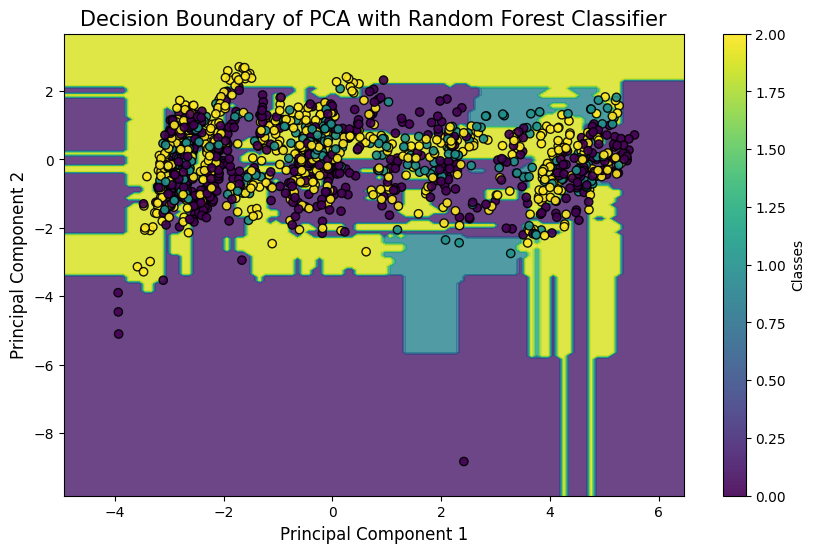

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()
# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 創建標籤欄位
df['Label'] = None
w = 30  # 歷史窗口大小
h = 7   # 預測視窗大小

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'  # 上升
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'  # 下降
    else:
        df.at[df.index[t], 'Label'] = 'M'  # 保持

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇 (取多個欄位作為特徵)
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼 (將 U, D, M 轉換為數字)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 使用 SMOTE 進行上採樣處理以平衡類別
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before SMOTE: {dict(zip(y_values, y_counts))}")
smote = SMOTE(sampling_strategy={0: y_counts[0], 1: y_counts[1] * 5, 2: y_counts[2]}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
y_values, y_counts = np.unique(y_resampled, return_counts=True)
print(f"Class distribution after SMOTE: {dict(zip(y_values, y_counts))}")

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# 應用 PCA 將數據降維到 2 維
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# 使用 GridSearchCV 調整隨機森林參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_pca, y_train)

# 使用最佳參數訓練隨機森林分類器
best_rf_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_rf_clf, X_train_pca, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪製決策邊界
plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

# 繪製數據點
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', alpha=0.9, cmap='viridis')
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.title('Decision Boundary of PCA with Random Forest Classifier', fontsize=15)
plt.colorbar(scatter, label='Classes')
plt.show()


# 新增區段

Class distribution before resampling: {0: 719, 1: 60, 2: 701}
Class distribution after resampling: {0: 719, 1: 180, 2: 701}
Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Average Cross-Validation Score: 0.6648


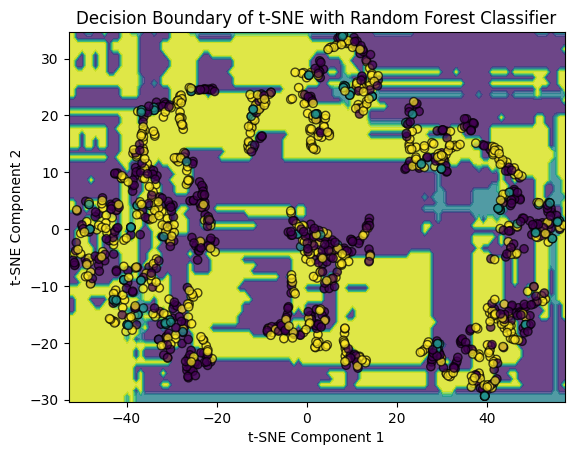

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()

# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 布林帶 (Bollinger Bands)
df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()  # 中線 (20天移動平均)
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()  # 上軌
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()  # 下軌

# 移動平均線收斂背離 (MACD)
ema_12 = df['Adj Close'].ewm(span=12, adjust=False).mean()  # 12天指數移動平均 (EMA)
ema_26 = df['Adj Close'].ewm(span=26, adjust=False).mean()  # 26天指數移動平均 (EMA)
df['MACD'] = ema_12 - ema_26  # MACD 線
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()  # 信號線 (9天 EMA)

# 創建標籤欄位
df['Label'] = None
w = 30  # 歷史窗口大小
h = 7   # 預測視窗大小

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'  # 上升
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'  # 下降
    else:
        df.at[df.index[t], 'Label'] = 'M'  # 保持

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇 (取多個欄位作為特徵)
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼 (將 U, D, M 轉換為數字)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 使用 resample 進行上採樣處理以平衡類別
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before resampling: {dict(zip(y_values, y_counts))}")

# 將原始資料劃分為三個類別
class_0 = labeled_df[y_encoded == 0]
class_1 = labeled_df[y_encoded == 1]
class_2 = labeled_df[y_encoded == 2]

# 對類別 1 進行上採樣，增加一些樣本
class_1_upsampled = resample(class_1,
                             replace=True,             # 允許重複選取
                             n_samples=int(y_counts[1] * 3),  # 增加到原始樣本的3倍
                             random_state=42)

# 合併類別，類別 0 和 2 保持不變，只增加類別 1 的樣本
resampled_df = pd.concat([class_0, class_1_upsampled, class_2])

# 重新定義 X 和 y
X_resampled = resampled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal']]
y_resampled = resampled_df['Label']

# 對標籤進行編碼
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# 查看最終分佈
y_values, y_counts = np.unique(y_resampled_encoded, return_counts=True)
print(f"Class distribution after resampling: {dict(zip(y_values, y_counts))}")

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled_encoded, test_size=0.2, random_state=42)

# 使用 t-SNE 進行降維
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)
X_test_tsne = tsne.fit_transform(X_test)

# 使用 GridSearchCV 調整隨機森林參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', 'balanced_subsample', None]
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tsne, y_train)

# 使用最佳參數訓練隨機森林分類器
best_rf_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_rf_clf, X_train_tsne, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界
x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪製決策邊界
plt.contourf(xx, yy, Z, alpha=0.8, cmap='viridis')

# 繪製數據點
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, edgecolor='k', alpha=0.7, cmap='viridis')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Decision Boundary of t-SNE with Random Forest Classifier')
plt.show()


Class distribution before resampling: {0: 719, 1: 60, 2: 701}
Class distribution after resampling: {0: 719, 1: 180, 2: 701}
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Average Cross-Validation Score: 0.6656


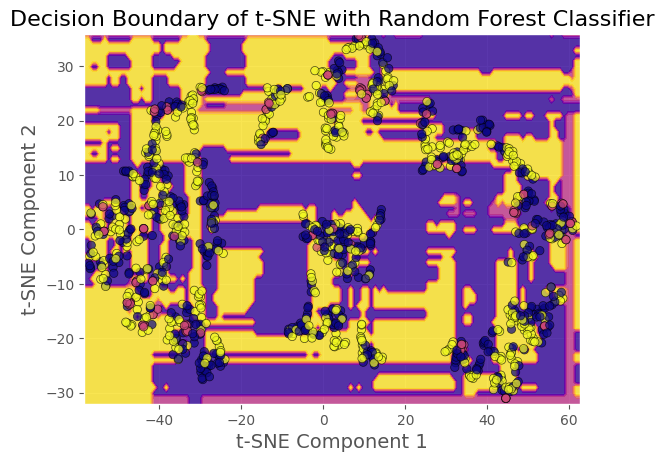

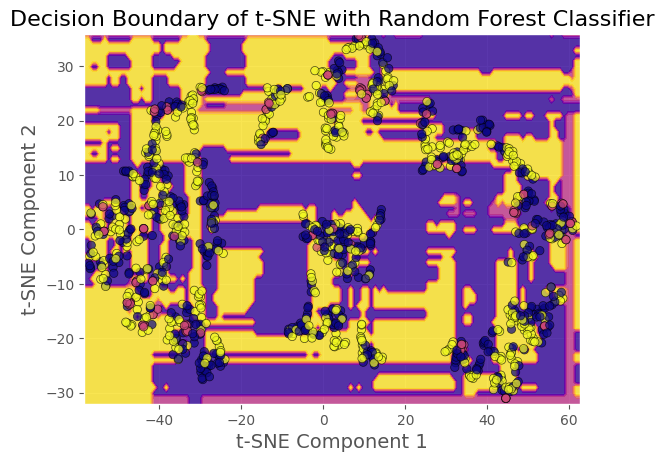

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()

# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 布林帶 (Bollinger Bands)
df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()

# 移動平均線收斂背離 (MACD)
ema_12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 創建標籤欄位
df['Label'] = None
w = 30
h = 7

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'
    else:
        df.at[df.index[t], 'Label'] = 'M'

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 查看最終分佈
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before resampling: {dict(zip(y_values, y_counts))}")

# 將原始資料劃分為三個類別
class_0 = labeled_df[y_encoded == 0]
class_1 = labeled_df[y_encoded == 1]
class_2 = labeled_df[y_encoded == 2]

# 對類別 1 進行上採樣
class_1_upsampled = resample(class_1,
                             replace=True,
                             n_samples=int(y_counts[1] * 3),
                             random_state=42)

# 合併類別，類別 0 和 2 保持不變，只增加類別 1 的樣本
resampled_df = pd.concat([class_0, class_1_upsampled, class_2])

# 重新定義 X 和 y
X_resampled = resampled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal']]
y_resampled = resampled_df['Label']

# 對標籤進行編碼
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# 查看最終分佈
y_values, y_counts = np.unique(y_resampled_encoded, return_counts=True)
print(f"Class distribution after resampling: {dict(zip(y_values, y_counts))}")

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled_encoded, test_size=0.2, random_state=42)

# 使用 t-SNE 進行降維
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train)

# 使用 GridSearchCV 調整隨機森林參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tsne, y_train)

# 使用最佳參數訓練隨機森林分類器
best_rf_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_rf_clf, X_train_tsne, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界

# 使用 ggplot 樣式改善整體視覺效果
plt.style.use('ggplot')

# 繪製決策邊界
x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap='plasma')

# 繪製數據點
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, edgecolor='k', alpha=0.7, cmap='plasma')
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('Decision Boundary of t-SNE with Random Forest Classifier', fontsize=16)
plt.show()


# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap='plasma')

# 繪製數據點
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, edgecolor='k', alpha=0.7, cmap='plasma')
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('Decision Boundary of t-SNE with Random Forest Classifier', fontsize=16)
plt.show()


Class distribution before resampling: {0: 719, 1: 60, 2: 702}
Class distribution after resampling: {0: 719, 1: 180, 2: 702}
Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Average Cross-Validation Score: 0.6695


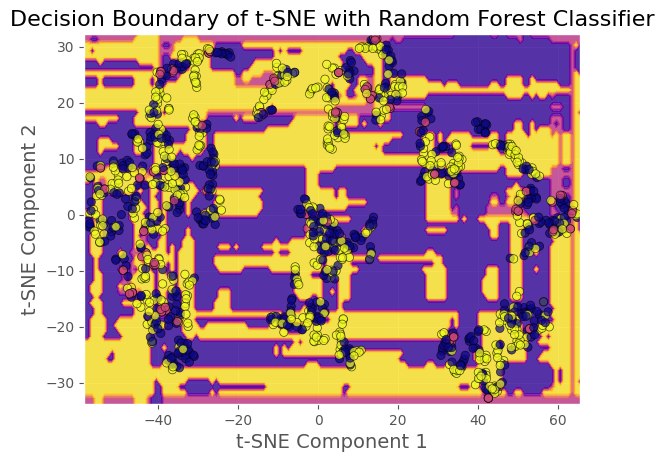

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()

# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 布林帶 (Bollinger Bands)
df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()

# 移動平均線收斂背離 (MACD)
ema_12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 創建標籤欄位
df['Label'] = None
w = 30
h = 7

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'
    else:
        df.at[df.index[t], 'Label'] = 'M'

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 查看最終分佈
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before resampling: {dict(zip(y_values, y_counts))}")

# 將原始資料劃分為三個類別
class_0 = labeled_df[y_encoded == 0]
class_1 = labeled_df[y_encoded == 1]
class_2 = labeled_df[y_encoded == 2]

# 對類別 1 進行上採樣
class_1_upsampled = resample(class_1,
                             replace=True,
                             n_samples=int(y_counts[1] * 3),
                             random_state=42)

# 合併類別，類別 0 和 2 保持不變，只增加類別 1 的樣本
resampled_df = pd.concat([class_0, class_1_upsampled, class_2])

# 重新定義 X 和 y
X_resampled = resampled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal']]
y_resampled = resampled_df['Label']

# 對標籤進行編碼
y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# 查看最終分佈
y_values, y_counts = np.unique(y_resampled_encoded, return_counts=True)
print(f"Class distribution after resampling: {dict(zip(y_values, y_counts))}")

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled_encoded, test_size=0.2, random_state=42)

# 使用 t-SNE 進行降維
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train)

# 使用 GridSearchCV 調整隨機森林參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tsne, y_train)

# 使用最佳參數訓練隨機森林分類器
best_rf_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_rf_clf, X_train_tsne, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界

# 使用 ggplot 樣式改善整體視覺效果
plt.style.use('ggplot')

# 繪製決策邊界
x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),
                     np.arange(y_min, y_max, 1))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap='plasma')

# 繪製數據點
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, edgecolor='k', alpha=0.7, cmap='plasma')
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('Decision Boundary of t-SNE with Random Forest Classifier', fontsize=16)
plt.show()


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Average Cross-Validation Score: 0.6695


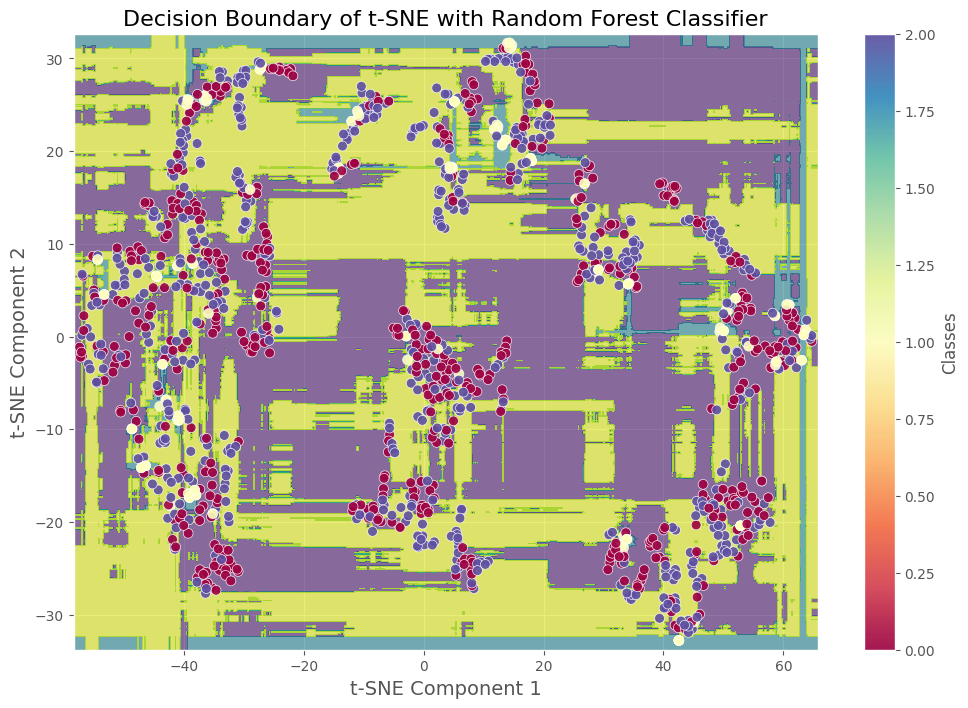

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE

# 使用 t-SNE 進行降維
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train)

# 使用 GridSearchCV 調整隨機森林參數
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced', 'balanced_subsample']
}
rf_clf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_tsne, y_train)

# 使用最佳參數訓練隨機森林分類器
best_rf_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉驗證評估模型性能
cv_scores = cross_val_score(best_rf_clf, X_train_tsne, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 繪製決策邊界

# 使用 ggplot 樣式改善整體視覺效果
plt.style.use('ggplot')

# 繪製決策邊界
x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),  # 減小步長以增加平滑度
                     np.arange(y_min, y_max, 0.05))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 增加圖表美化
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.6, cmap='viridis')  # 改變顏色映射為 'viridis' 並增大透明度以使背景更柔和

# 繪製數據點
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, edgecolor='white', alpha=0.9, cmap='Spectral', s=50)  # 使用 'Spectral' 顏色映射，增加點的大小
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('Decision Boundary of t-SNE with Random Forest Classifier', fontsize=16)
plt.colorbar(label='Classes')
plt.show()


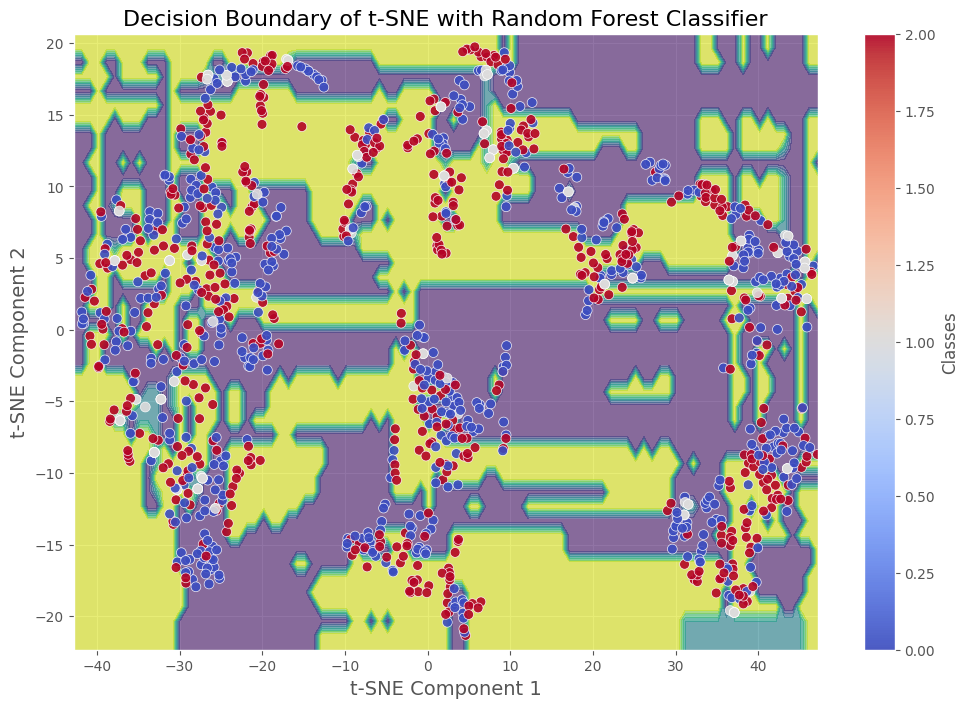

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.manifold import TSNE

# 使用 t-SNE 進行降維
tsne = TSNE(n_components=2, random_state=42, perplexity=50, learning_rate=100)  # 調整 perplexity 和 learning_rate
X_train_tsne = tsne.fit_transform(X_train)

# 使用最佳參數訓練隨機森林分類器（假設已經找到最佳參數 best_rf_clf）
best_rf_clf.fit(X_train_tsne, y_train)

# 繪製決策邊界

# 使用 'ggplot' 样式改善整体视觉效果
plt.style.use('ggplot')

# 繪製決策邊界
x_min, x_max = X_train_tsne[:, 0].min() - 1, X_train_tsne[:, 0].max() + 1
y_min, y_max = X_train_tsne[:, 1].min() - 1, X_train_tsne[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 1),  # 使用较大步长减少细碎片段
                     np.arange(y_min, y_max, 1))

# 使用模型進行預測
Z = best_rf_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.6, cmap='viridis')  # 使用 'viridis' 映射并增加透明度

# 繪製數據點
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, edgecolor='white', alpha=0.9, cmap='coolwarm', s=50)  # 使用 'coolwarm' 颜色映射使类别更显著
plt.xlabel('t-SNE Component 1', fontsize=14)
plt.ylabel('t-SNE Component 2', fontsize=14)
plt.title('Decision Boundary of t-SNE with Random Forest Classifier', fontsize=16)
plt.colorbar(label='Classes')
plt.show()


In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 对测试集进行降维 (t-SNE 对测试集)
X_test_tsne = tsne.fit_transform(X_test)

# 使用模型进行预测
y_pred = best_rf_clf.predict(X_test_tsne)

# 计算模型的准确率
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# 打印混淆矩阵和分类报告
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# 分类报告（包含精确率、召回率和 F1-score）
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)


Test Accuracy: 0.4330
Confusion Matrix:
[[75  5 79]
 [18  2 10]
 [70  0 62]]
Classification Report:
              precision    recall  f1-score   support

           D       0.46      0.47      0.47       159
           M       0.29      0.07      0.11        30
           U       0.41      0.47      0.44       132

    accuracy                           0.43       321
   macro avg       0.39      0.34      0.34       321
weighted avg       0.42      0.43      0.42       321



In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 使用 XGBoost 替换随机森林

# 数据准备部分（保持不变）
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技术指标
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 创建标签
df['Label'] = None
w = 30
h = 7
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'
    else:
        df.at[df.index[t], 'Label'] = 'M'

labeled_df = df[df['Label'].notna()]

# 特征选择
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y = labeled_df['Label']
X = X.dropna()
y = y[X.index]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 重新采样
y_values, y_counts = np.unique(y_encoded, return_counts=True)
print(f"Class distribution before resampling: {dict(zip(y_values, y_counts))}")

class_0 = labeled_df[y_encoded == 0]
class_1 = labeled_df[y_encoded == 1]
class_2 = labeled_df[y_encoded == 2]
class_1_upsampled = resample(class_1, replace=True, n_samples=int(y_counts[1] * 3), random_state=42)
resampled_df = pd.concat([class_0, class_1_upsampled, class_2])
X_resampled = resampled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14']]
y_resampled = resampled_df['Label']

y_resampled_encoded = label_encoder.fit_transform(y_resampled)

# 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled_encoded, test_size=0.2, random_state=42)

# XGBoost 分类器
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_xgb_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用交叉验证评估模型性能
cv_scores = cross_val_score(best_xgb_clf, X_train, y_train, cv=5)
print(f"Average Cross-Validation Score: {cv_scores.mean():.4f}")

# 测试集上的评估
y_pred = best_xgb_clf.predict(X_test)

# 准确率和分类报告
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)


Class distribution before resampling: {0: 719, 1: 60, 2: 702}
Fitting 3 folds for each of 108 candidates, totalling 324 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:06:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:06:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:06:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:06:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:06:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:06:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Average Cross-Validation Score: 0.7063
Test Accuracy: 0.7850
Confusion Matrix:
[[117   3  39]
 [  3  27   0]
 [ 24   0 108]]
Classification Report:
              precision    recall  f1-score   support

           D       0.81      0.74      0.77       159
           M       0.90      0.90      0.90        30
           U       0.73      0.82      0.77       132

    accuracy                           0.79       321
   macro avg       0.82      0.82      0.82       321
weighted avg       0.79      0.79      0.79       321



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.4311 - loss: 0.9963 - val_accuracy: 0.5395 - val_loss: 0.8060
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.4907 - loss: 0.8447 - val_accuracy: 0.6082 - val_loss: 0.7983
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5385 - loss: 0.8327 - val_accuracy: 0.6357 - val_loss: 0.7807
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5589 - loss: 0.8297 - val_accuracy: 0.5601 - val_loss: 0.7733
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.6117 - loss: 0.7797 - val_accuracy: 0.6289 - val_loss: 0.7492
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6198 - loss: 0.7856 - val_accuracy: 0.6632 - val_loss: 0.7241
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.6178 - loss: 0.7815 - val_accuracy: 0.6495 - val_loss: 0.7202
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6434 - loss: 0.7471 - val_accuracy: 0.7113 - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


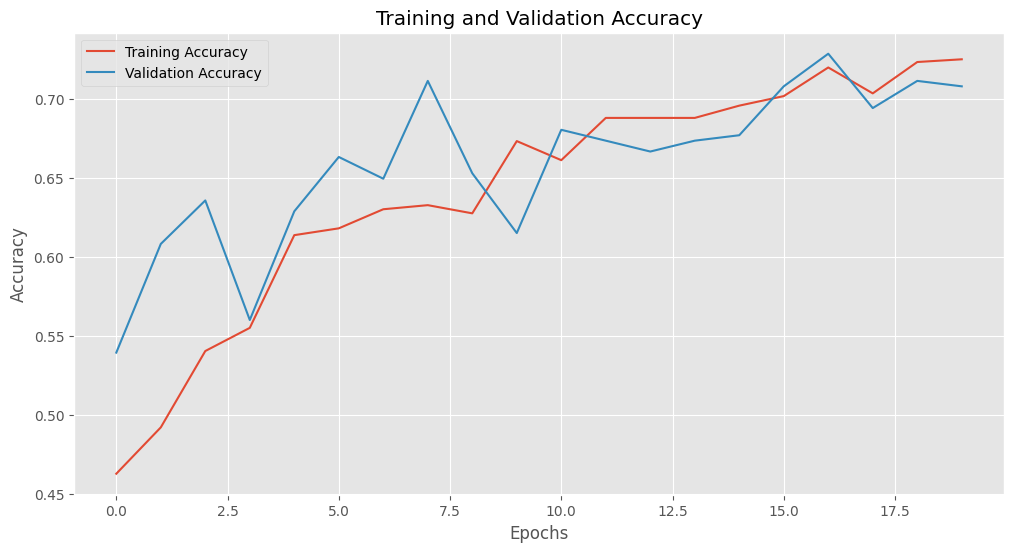

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.utils import to_categorical

# 讀取 CSV 文件
df = pd.read_csv("./MTCH_stock_data_2018_11_11_to_today.csv", skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()

# 相對強弱指標 (RSI)
delta = df['Adj Close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14, min_periods=1).mean()
avg_loss = loss.rolling(window=14, min_periods=1).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 布林帶 (Bollinger Bands)
df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()

# 移動平均線收斂背離 (MACD)
ema_12 = df['Adj Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 創建標籤欄位
df['Label'] = None
w = 30  # 歷史窗口大小
h = 7   # 預測視窗大小

# 根據調整收盤價創建標籤
for t in range(w, len(df) - h):
    P_w = df['Adj Close'].iloc[t - 1]
    P_wh = df['Adj Close'].iloc[t + h]
    return_value = (P_wh - P_w) / P_w

    if return_value > 0.005:
        df.at[df.index[t], 'Label'] = 'U'  # 上升
    elif return_value < -0.005:
        df.at[df.index[t], 'Label'] = 'D'  # 下降
    else:
        df.at[df.index[t], 'Label'] = 'M'  # 保持

# 過濾已標籤的資料
labeled_df = df[df['Label'].notna()]

# 特徵選擇 (取多個欄位作為特徵)
X = labeled_df[['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_30', 'RSI_14', 'BB_Middle', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal']]
y = labeled_df['Label']

# 去除包含 NaN 的樣本
X = X.dropna()
y = y[X.index]

# 對標籤進行編碼 (將 U, D, M 轉換為數字)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 轉換為序列資料以適用於 LSTM
sequence_length = 30  # 使用過去 30 天的數據進行預測
X_sequences = []
y_sequences = []

for i in range(sequence_length, len(X_scaled)):
    X_sequences.append(X_scaled[i-sequence_length:i])
    y_sequences.append(y_encoded[i])

X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences)

# 將數據分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# 對標籤進行 one-hot 編碼
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

# 建立 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 訓練模型
history = model.fit(X_train, y_train_categorical, epochs=20, batch_size=32, validation_data=(X_test, y_test_categorical))

# 評估模型性能
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)

# 打印分類報告和混淆矩陣
test_accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 可視化訓練過程
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 0.4476 - loss: 0.9674 - val_accuracy: 0.4914 - val_loss: 0.8697 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.5093 - loss: 0.8798 - val_accuracy: 0.5395 - val_loss: 0.7975 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.5316 - loss: 0.8586 - val_accuracy: 0.6117 - val_loss: 0.7739 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 0.5835 - loss: 0.7914 - val_accuracy: 0.6186 - val_loss: 0.7618 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.5961 - loss: 0.7905 - val_accuracy: 0.6254 - val_loss: 0.7547 - learning_rate: 0.0010
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 177ms/step - accuracy: 0.6278 - loss: 0.7745 - val_accuracy: 0.5773 - val_loss: 0.7628 - learning_rate: 0.0010
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.6302 - loss: 0.7668 -

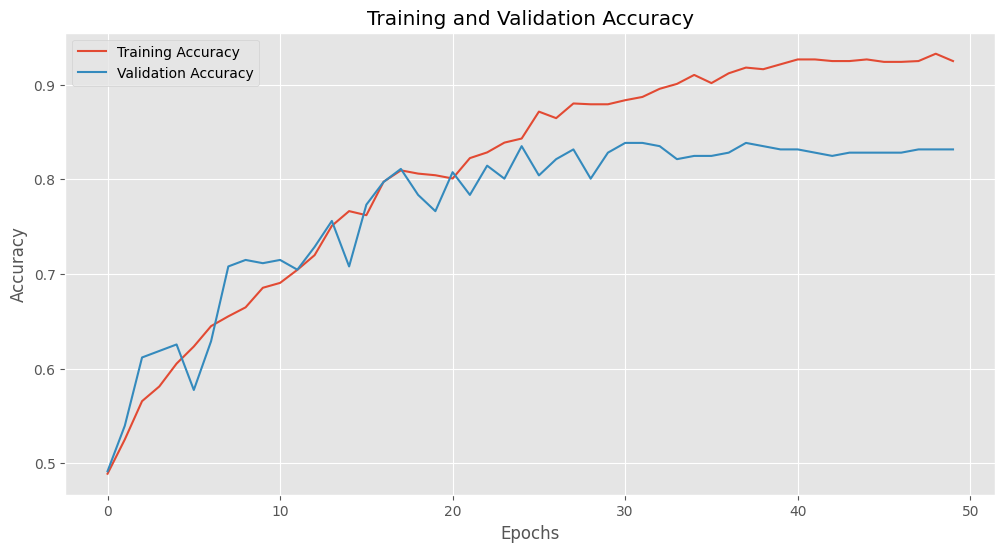

In [20]:
from keras.layers import Bidirectional
from keras.callbacks import ReduceLROnPlateau

# 修改后的 LSTM 模型構建
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=100)))
model.add(Dropout(0.3))
model.add(Dense(units=3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 使用學習率調度器
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001)

# 訓練模型
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_test, y_test_categorical), callbacks=[lr_scheduler])

# 繪製訓練過程的曲線
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 163ms/step
Classification Report:
              precision    recall  f1-score   support

           D       0.86      0.87      0.86       143
           M       0.00      0.00      0.00         8
           U       0.84      0.84      0.84       140

    accuracy                           0.83       291
   macro avg       0.57      0.57      0.57       291
weighted avg       0.83      0.83      0.83       291



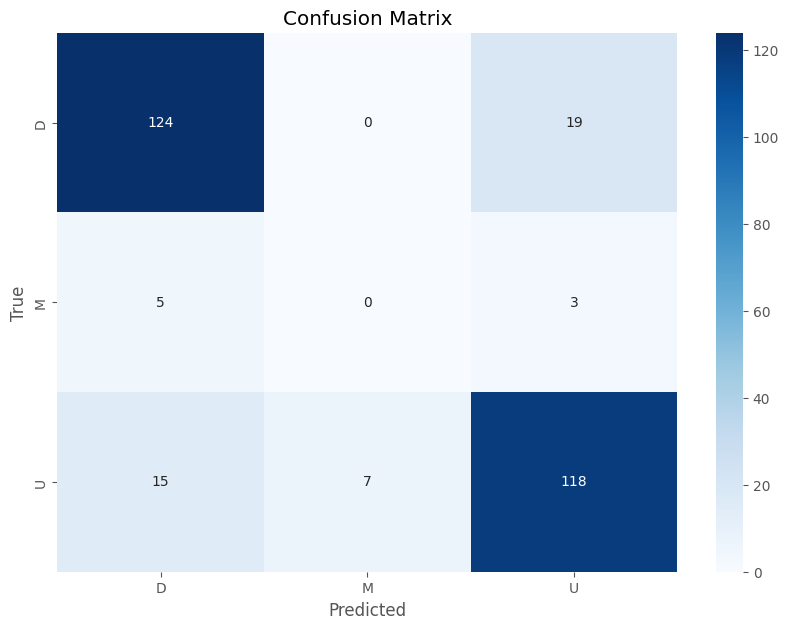

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# 使用測試集進行預測
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# 生成分類報告
class_report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

# 繪製混淆矩陣
conf_matrix = confusion_matrix(y_true, y_pred_classes)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Fitting 3 folds for each of 90 candidates, totalling 270 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Classification Report:
              precision    recall  f1-score   support

           D       0.72      0.78      0.75       144
           M       0.00      0.00      0.00        13
           U       0.71      0.64      0.67       140

    accuracy                           0.68       297
   macro avg       0.47      0.48      0.47       297
weighted avg       0.68      0.68      0.68       297



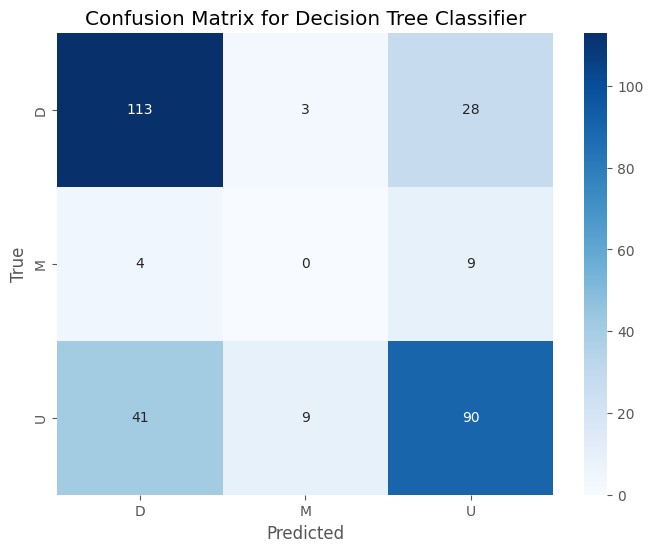

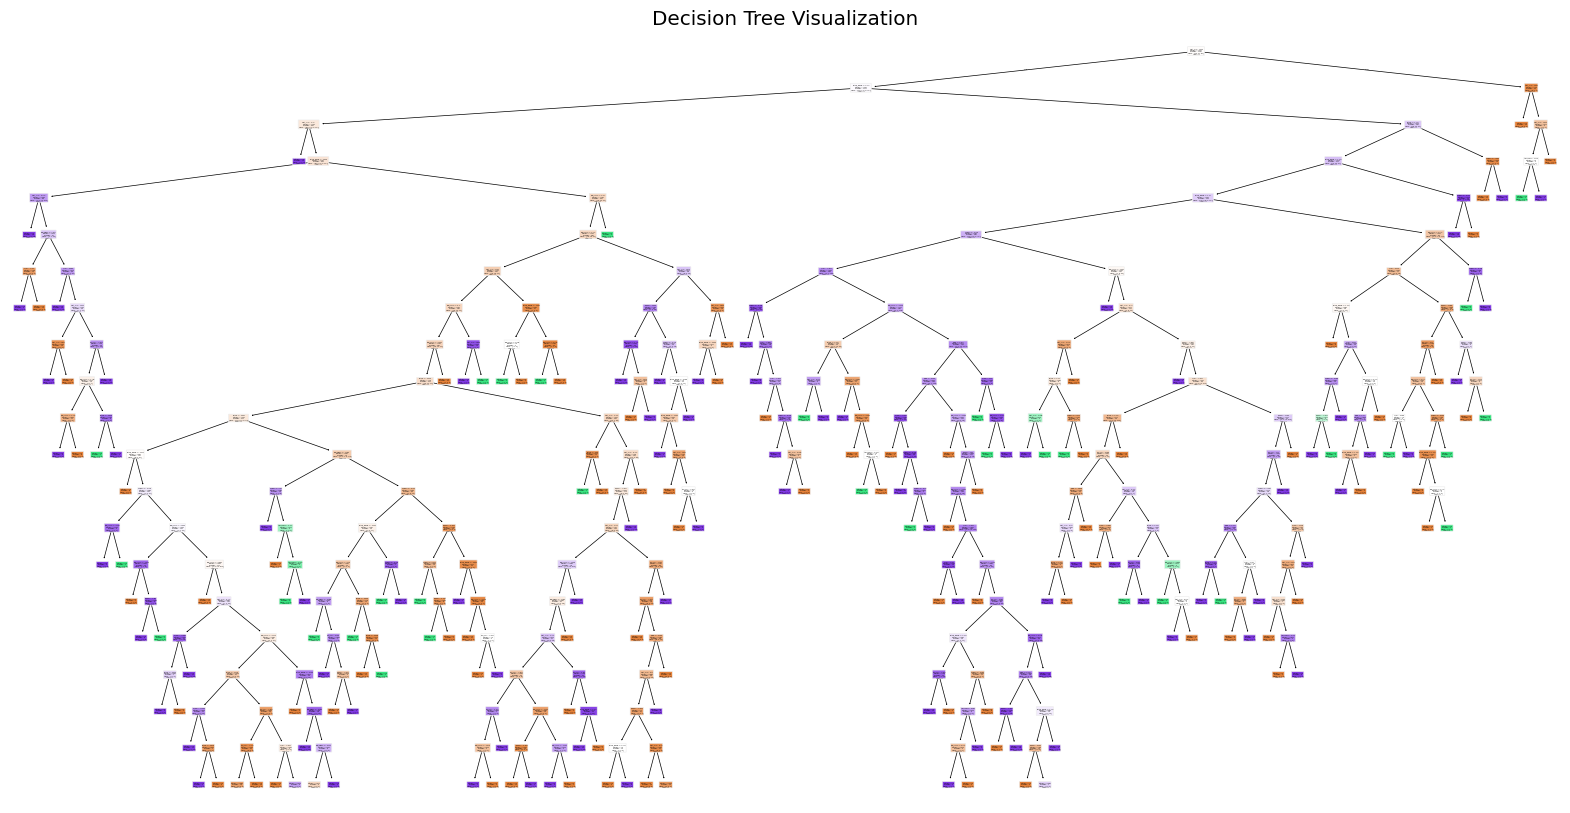

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 假設數據已經加載到 DataFrame 中，並已經經過適當的處理 (例如處理 NaN，生成特徵與標籤等)
# 我們從標準化數據開始

# 對特徵進行標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 將數據劃分為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# 使用 GridSearchCV 調整決策樹模型的超參數
param_grid = {
    'criterion': ['gini', 'entropy'],  # 分裂的衡量標準
    'max_depth': [5, 10, 15, 20, None],  # 決策樹的最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點所需的最少樣本數
    'min_samples_leaf': [1, 2, 4]  # 每個葉子節點所需的最少樣本數
}

# 初始化決策樹分類器
dt_clf = DecisionTreeClassifier(random_state=42)

# 使用 GridSearchCV 進行參數調整
grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# 使用最佳參數訓練決策樹模型
best_dt_clf = grid_search.best_estimator_
print(f"Best Parameters: {grid_search.best_params_}")

# 使用測試集進行預測
y_pred = best_dt_clf.predict(X_test)

# 打印分類報告
class_report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

# 繪製混淆矩陣
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

# 繪製決策樹
plt.figure(figsize=(20, 10))
plot_tree(best_dt_clf, filled=True, feature_names=X.columns, class_names=label_encoder.classes_, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


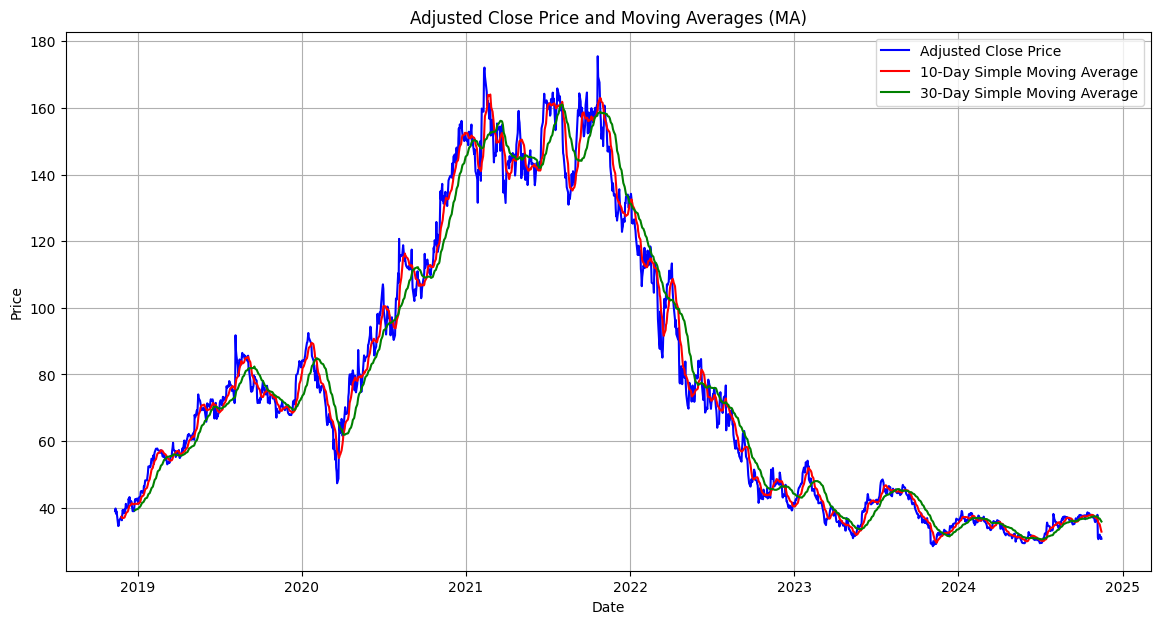

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = './MTCH_stock_data_2018_11_11_to_today.csv'
df = pd.read_csv(file_path, skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])

# Convert 'Date' to datetime format and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Calculate moving averages (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()

# Plotting the moving averages along with 'Adj Close'
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price', color='blue')
plt.plot(df.index, df['SMA_10'], label='10-Day Simple Moving Average', color='red')
plt.plot(df.index, df['SMA_30'], label='30-Day Simple Moving Average', color='green')
plt.title('Adjusted Close Price and Moving Averages (MA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()


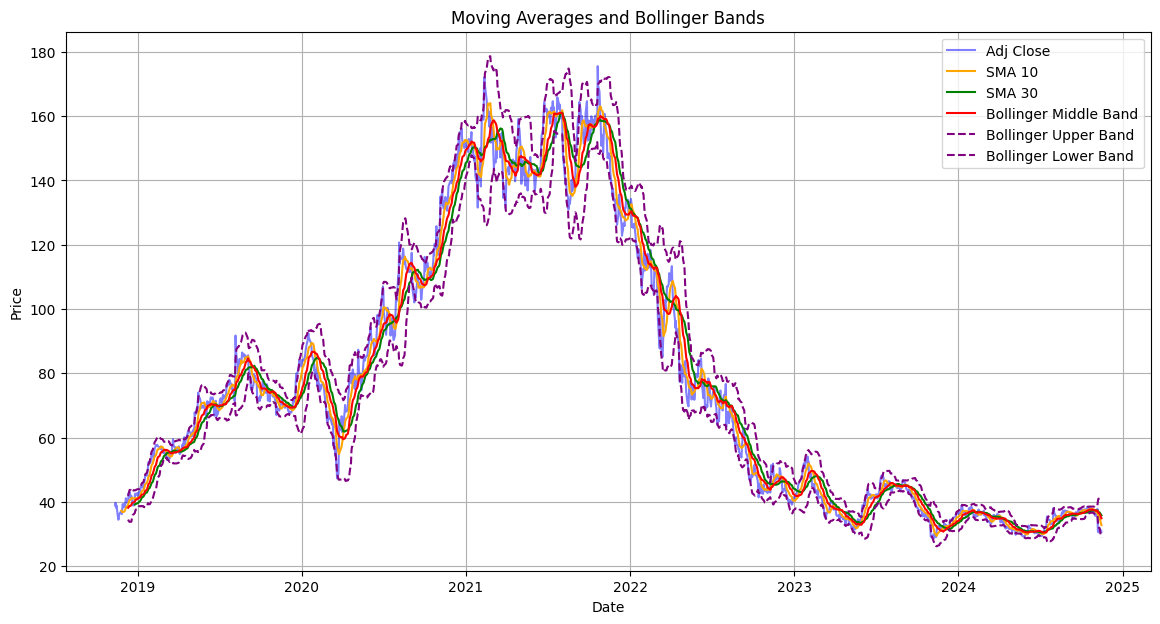

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = './MTCH_stock_data_2018_11_11_to_today.csv'
df = pd.read_csv(file_path, skiprows=3, names=["Date", "Adj Close", "Close", "High", "Low", "Open", "Volume"])
# 將 'Date' 列轉換為日期格式，並設置為索引
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 添加技術指標
# 移動平均線 (MA)
df['SMA_10'] = df['Adj Close'].rolling(window=10).mean()
df['SMA_30'] = df['Adj Close'].rolling(window=30).mean()

# 布林帶 (Bollinger Bands)
df['BB_Middle'] = df['Adj Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Adj Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Adj Close'].rolling(window=20).std()

# 繪製移動平均線和布林帶
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['Adj Close'], label='Adj Close', color='blue', alpha=0.5)
plt.plot(df.index, df['SMA_10'], label='SMA 10', color='orange')
plt.plot(df.index, df['SMA_30'], label='SMA 30', color='green')
plt.plot(df.index, df['BB_Middle'], label='Bollinger Middle Band', color='red')
plt.plot(df.index, df['BB_Upper'], label='Bollinger Upper Band', color='purple', linestyle='--')
plt.plot(df.index, df['BB_Lower'], label='Bollinger Lower Band', color='purple', linestyle='--')

plt.title('Moving Averages and Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

In [7]:
pwd


'/content'